# Twitter Sentiment Analysis

## Connect to Twitter API

In [4]:
#!pip install python-twitter
import twitter
import pandas as pd
import nltk
import re
import multiprocessing as mp

nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing import sequence
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package words to /home/eliska/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/eliska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/eliska/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
API_KEY = "4QlG7dBQ1UeHAXyk1pC6n7LTm"
API_KEY_SECRET = "td6zhDHTI795WKXGYjXBJUwba9xCyxZ3o73VYro9XtLrQD30UZ"
ACCESS_TOKEN = "1067118225744371712-8rjdKc3f2rFNf7FXczj5T3X1W6yfu4"
ACCESS_TOKEN_SECRET = "Hw1A7nii1S2JAh0hMgkR6xZB1IddC1KAgJBPI5OaoQnSv"

# initialize api instance
twitter_api = twitter.Api(consumer_key=API_KEY,
                  consumer_secret=API_KEY_SECRET,
                  access_token_key=ACCESS_TOKEN,
                  access_token_secret=ACCESS_TOKEN_SECRET)

# test authentication
print(twitter_api.VerifyCredentials())

{"created_at": "Mon Nov 26 18:09:45 +0000 2018", "default_profile": true, "default_profile_image": true, "friends_count": 2, "id": 1067118225744371712, "id_str": "1067118225744371712", "name": "EliskaKloberdanz", "profile_background_color": "F5F8FA", "profile_image_url": "http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png", "profile_image_url_https": "https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png", "profile_link_color": "1DA1F2", "profile_sidebar_border_color": "C0DEED", "profile_sidebar_fill_color": "DDEEF6", "profile_text_color": "333333", "profile_use_background_image": true, "screen_name": "EliskaKloberda1"}


## Search Twitter for any key word for which you want to analyze sentiment

In [6]:
# serach tweets by key words
def buildTestSet(search_keyword):
    text = []
    try:
        tweets_fetched = twitter_api.GetSearch(search_keyword, count=100)
        print("Fetched " + str(len(tweets_fetched)) + " tweets for the term " + search_keyword)
        for status in tweets_fetched:
            text.append(status.text)
        return pd.DataFrame({'tweet_text': text})
        #return [{"text":status.text, "label":None} for status in tweets_fetched]
    except:
        print("Unfortunately, something went wrong..")
        return None

In [7]:
search_term = input("Enter a search keyword: ")
testDataSet = buildTestSet(search_term)

print(testDataSet[0:4])

Enter a search keyword: oil
Fetched 100 tweets for the term oil
                                          tweet_text
0  This filthy tabloid has decided to hide name o...
1  Our Creative Industries give more to the UK GD...
2  Hey Goldman Sachs, 2014 just called and asked ...
3  .@bp_plc - if you really want to be part of th...


## Build Train Set

In [8]:
corpus = pd.read_csv('labeled_training_set.csv', encoding='latin-1')
corpus.columns = ['label', 'tweet_id', 'date', 'flag', 'user', 'tweet_text']
corpus.head(6)

,label,tweet_id,date,flag,user,tweet_text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug


## Data Pre-processing

In [9]:
# Drop NaNs
trainingData = corpus.copy()
trainingData = trainingData[trainingData['tweet_text'].isnull() == False]

# Unique Labels
trainingData['label'].unique()

# Downsample data
from sklearn.utils import shuffle
trainingData = shuffle(trainingData)
#trainingData = trainingData.iloc[:10000, :]

# Check dirstibution of labels
trainingData.groupby('label').size()


label
0    799999
4    800000
dtype: int64

In [10]:
stop = nltk.corpus.stopwords.words('english')
def preprocess_text(text):
    text=text.lower()
    text=re.sub('[^0-9a-zA-Z]+',' ',text)
    words = text.split()
    words2=[w for w in words if (w not in stop)]
    #words3=[ps.stem(w) for w in words]
    words4=' '.join(words2)
    return(words4)


In [11]:
# multithreaded data pre-processing
with mp.Pool() as pool:
    tokens = pool.map(preprocess_text, trainingData.tweet_text)

In [12]:
tokens

['man wish vegitables',
 'got silver frequent flyer card',
 'surfing 2mow amp going 2 b able 2 play goalie 4 2mow nights soccer game',
 'sunlight plain white ts sweet',
 'want polaroid',
 'great looks like need new car',
 'kat77 well guess commiserate together',
 'sun shinin stuck office boo',
 'finally home already feel tension',
 'hate throat hurting funny voice even tho funny hurting',
 'behind fanlistings lot work',
 'teaching today',
 'xxamberaxx hearts',
 'going north weekend looking forward long drive',
 'cairns holden commodore 1997 3 500 new ad received posted hcc site soon',
 'hate scorching sun hope rains',
 'swifty7 eek try quot happy quot good tip',
 'someoneeee loan 60 fix tireeee',
 'yungcutup lol sorry getting back u soon hey happy tuesday big plans 4 today',
 'luke94 like new avatar',
 'keelygreer course cable able watch sd version quite time tell dh',
 'justant1 yoooo thanks u deleted ur tweet didnt get chance respond got though thank u u gonna keep posted',
 'bad day

In [13]:
trainingData.tweet_text = tokens
trainingData.to_csv('trainingData_clean.csv')

In [14]:
#trainingData = pd.read_csv('trainingData_clean.csv')
trainingData = shuffle(trainingData)

In [15]:
with mp.Pool() as pool:
    tokens_test = pool.map(preprocess_text, testDataSet.tweet_text)
testDataSet.tweet_text = tokens_test
testDataSet.head(5)

,tweet_text
0,filthy tabloid decided hide name malik riaz da...
1,creative industries give uk gdp oil car indust...
2,hey goldman sachs 2014 called asked talking po...
3,bp plc really want part cleaner healthier resi...
4,step 1 setting lot get ready making soap first...


In [16]:
trainingData = trainingData.dropna()
trainingData.head(4)

,label,tweet_id,date,flag,user,tweet_text
814545,4,1550847982,Sat Apr 18 07:26:13 PDT 2009,NO_QUERY,shirinloh,study tools panadol sugar free redbull
1067326,4,1965468885,Fri May 29 15:58:38 PDT 2009,NO_QUERY,Whipoorwill,jeff0134 okay meet
661715,0,2243308646,Fri Jun 19 13:17:06 PDT 2009,NO_QUERY,psychodwarf,gwiazda sounds good love lie taking hubby work...
1427589,4,2059415247,Sat Jun 06 16:53:17 PDT 2009,NO_QUERY,JusRite,chillen bronx


In [17]:
trainingData.groupby('label').size()


label
0    799999
4    800000
dtype: int64

In [18]:
from collections import Counter
counts = Counter()
for i,review in enumerate(trainingData['tweet_text']):
    counts.update(review.split())

In [19]:
words = sorted(counts, key=counts.get, reverse=True)
word_to_int = {word: i for i, word in enumerate(words, 1)}

In [20]:
mapped_reviews = []
for review in trainingData['tweet_text']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])

In [21]:
length_sent = []
for i in range(len(mapped_reviews)):
  length_sent.append(len(mapped_reviews[i]))
max(length_sent)

50

In [22]:
from keras.preprocessing.sequence import pad_sequences


sequence_length = max(length_sent)
# X = sequence.pad_sequences(trainingData_encoded, maxlen=max_words)
X = pad_sequences(maxlen=sequence_length, sequences=mapped_reviews, padding="post", value=0)
X

array([[  476,  4255, 16008, ...,     0,     0,     0],
       [68733,   246,   361, ...,     0,     0,     0],
       [59622,   220,     1, ...,     0,     0,     0],
       ...,
       [  102, 14707,    50, ...,     0,     0,     0],
       [23092,     1,    38, ...,     0,     0,     0],
       [  138,  8672,  1186, ...,     0,     0,     0]], dtype=int32)

In [23]:
X.shape

(1599999, 50)

In [24]:
y = trainingData['label'].values
print(len(y))
print(len(X))

1599999
1599999


In [25]:
set(y)

{0, 4}

In [26]:
for i in range(len(y)):
    if y[i] == 4:
        y[i] = 1


In [27]:
y

array([1, 1, 0, ..., 1, 1, 0])

In [28]:
from keras.utils import to_categorical
y = to_categorical(y, num_classes=2)
y

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

## Split data intro train and test sets

In [29]:
# Split data into traning and testing


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


## Model

In [30]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embedding_size=100
model=Sequential()
model.add(Embedding(input_dim=1000000, output_dim = embedding_size, input_length=sequence_length))
model.add(LSTM(40, return_sequences=True))
model.add(LSTM(40, return_sequences=False))
model.add(Dense(2, activation='softmax')) # binary output

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           100000000 
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 40)            22560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 82        
Total params: 100,035,602
Trainable params: 100,035,602
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
model.compile(loss='categorical_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [32]:
batch_size = 1000
num_epochs = 10
# X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
# X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]
# X_train2

In [33]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15365927207081389241
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9596763534504835922
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12235987807003700964
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7785862944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9744848199340083054
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:0a:00.0, compute capability: 6.1"
]


In [36]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=num_epochs)

/home/eliska/gpu-keras-env/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1071999 samples, validate on 528000 samples
Epoch 1/10
1071999/1071999 [==============================] - 180s 168us/step - loss: 0.4957 - accuracy: 0.7464 - val_loss: 0.4523 - val_accuracy: 0.7859
Epoch 2/10
1071999/1071999 [==============================] - 180s 167us/step - loss: 0.3844 - accuracy: 0.8265 - val_loss: 0.4664 - val_accuracy: 0.7814
Epoch 3/10
1071999/1071999 [==============================] - 179s 167us/step - loss: 0.2894 - accuracy: 0.8756 - val_loss: 0.5078 - val_accuracy: 0.7741
Epoch 4/10
1071999/1071999 [==============================] - 179s 167us/step - loss: 0.2259 - accuracy: 0.9038 - val_loss: 0.5989 - val_accuracy: 0.7675
Epoch 5/10
1071999/1071999 [==============================] - 180s 168us/step - loss: 0.1857 - accuracy: 0.9203 - val_loss: 0.6971 - val_accuracy: 0.7680
Epoch 6/10
1071999/1071999 [==============================] - 180s 168us/step - loss: 0.1594 - accuracy: 0.9311 - val_loss: 0.7754 - val_accuracy: 0.7617
Epoch 7/10
1071999/1071

In [37]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.750607967376709


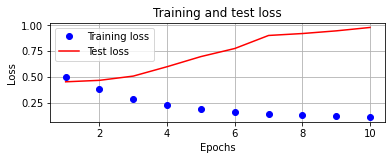

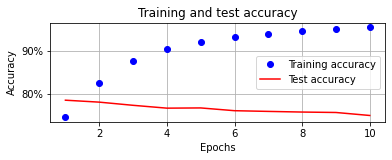

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.ticker as mtick
plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [40]:
history_dict

{'val_loss': [0.45225917186700937,
  0.46644476705202553,
  0.5077836388778506,
  0.5989202078093182,
  0.6971280235006954,
  0.775402706906651,
  0.9020079028877345,
  0.9207472350787033,
  0.9466749892541857,
  0.979704894012574],
 'val_accuracy': [0.7859242558479309,
  0.7814394235610962,
  0.7741155028343201,
  0.7675416469573975,
  0.7680473327636719,
  0.7616534233093262,
  0.7600321769714355,
  0.75853031873703,
  0.757535994052887,
  0.750607967376709],
 'loss': [0.4956679058070792,
  0.3844450317778771,
  0.28943860410053673,
  0.2259176745626088,
  0.18566889937879374,
  0.15940268723800471,
  0.14050784500089017,
  0.12729568529290733,
  0.11618603970206519,
  0.10770973058159812],
 'accuracy': [0.7463869,
  0.8264998,
  0.8756482,
  0.90376204,
  0.92026114,
  0.9311277,
  0.9393777,
  0.9450382,
  0.94985723,
  0.954027]}

In [44]:
# Save model
import pickle
# Save to file in the current working directory
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)
